## Homework 4

In this homework, we will use the lead scoring dataset.  
In this dataset our desired target for classification task will be converted variable - has the client signed up to the platform or not.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [39]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-11-14 22:52:00--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.1’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.003s  

2025-11-14 22:52:00 (28.3 MB/s) - ‘course_lead_scoring.csv.1’ saved [80876/80876]



In [40]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [41]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [42]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [43]:
categorical_features = list(df.dtypes[df.dtypes == 'object'].index)
numerical_variables = list(df.dtypes[df.dtypes != 'object'].index)

# From the output below, numerical_fetures includes converted variable which is our target therefore the tagert variable has to be removed
features = (categorical_features + numerical_variables)
features.remove('converted')

print('Categorical Columns')
print(categorical_features)
print()
print('Numerical Columns')
print(numerical_variables)
print()
print('Features')
print(features)

Categorical Columns
['lead_source', 'industry', 'employment_status', 'location']

Numerical Columns
['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score', 'converted']

Features
['lead_source', 'industry', 'employment_status', 'location', 'number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [44]:
# To see only columns that have missing values
df.isnull().sum()[df.isnull().sum() != 0]

lead_source          128
industry             134
annual_income        181
employment_status    100
location              63
dtype: int64

In [45]:
# for categorical variables, missing values are replaced with 'NA'
# df.lead_source = df.lead_source.fillna('NA')
# df.industry = df.industry.fillna('NA')
# df.employment_status = df.employment_status.fillna('NA')
# df.location = df.location.fillna('NA')

# for numerical variables, missing values are replaced with 0
# df.annual_income = df.annual_income.fillna(0)

# Cleaner way
df[categorical_features] = df[categorical_features].fillna('NA')
df[numerical_variables] = df[numerical_variables].fillna(0.0)


In [46]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [47]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [48]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [49]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [50]:
X_train = df_train[features]
X_val = df_val[features]
X_test = df_val[features]

In [51]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [52]:
from sklearn.metrics import roc_auc_score

In [53]:
roc_scores = {}

numerical_features = [x for x in numerical_variables if x != "converted"]


for var in numerical_features:
    # Getting each feature as a prediction as suggested by the question
    y_pred = df_train[var].values

    auc = roc_auc_score(y_train, y_pred)

    if auc < 0.5:
        y_pred = -df_train[var].values
        auc = roc_auc_score(y_train, y_pred)
    
    # store roc score
    roc_scores[var] = auc


In [54]:
max_score = max(roc_scores, key=roc_scores.get)
print(f"The numerical variable with the highest AUC is {max_score} AUC = {round(roc_scores[max_score], 4)}")

The numerical variable with the highest AUC is number_of_courses_viewed AUC = 0.755


Q1 Ans: The numerical variable with the highest AUC is number_of_courses_viewed

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92


In [55]:
# One hot encoding
from sklearn.feature_extraction import DictVectorizer

In [56]:
dv = DictVectorizer(sparse=False)

In [57]:
X_train_dict = X_train.to_dict(orient='records')
X_train_Q2 = dv.fit_transform(X_train_dict)

X_val_dict = X_val.to_dict(orient='records')
X_val_Q2 = dv.transform(X_val_dict)

In [58]:
# Training logistic regression with Scikit-Learn
from sklearn.linear_model import LogisticRegression

In [59]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train_Q2, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [60]:
model.intercept_[0]

np.float64(-0.06914728027824993)

In [61]:
model.coef_[0].round(3)

array([-0.   , -0.015,  0.034,  0.003,  0.012, -0.103, -0.025,  0.049,
       -0.02 , -0.013, -0.003, -0.009, -0.032, -0.016,  0.311,  0.051,
        0.02 , -0.012, -0.012, -0.115,  0.08 , -0.03 ,  0.004, -0.011,
       -0.011, -0.006,  0.008,  0.006, -0.033, -0.025,  0.454])

In [62]:
y_pred = model.predict_proba(X_val_Q2)[:, 1]

auc  = roc_auc_score(y_val, y_pred)

print(f'The AUC of this model on the validation dataset is {round(auc, 4)}')

The AUC of this model on the validation dataset is 0.8549


Q2 Ans: The AUC of this model on the validation dataset is 0.8549

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [63]:

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

thresholds = np.arange(0.0, 1.01, 0.01)
# Alternatively
# thresholds = np.linspace(0, 1, 101)

# empty list of tuples where each tuple contains threshold, the precision and recall scores at each trheshold
scores = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    confusion_matrix = np.array([
        [tn, fp],
        [fn, tp]
    ]) # I added Confusion matrix here for study purpose. It is not really for this task

    # Precision
    p = tp / (tp + fp)

    # Recall
    r = tp / (tp + fn)

    # store precision and recall in a df named df_scores
    scores.append((t, p, r,  tp, fp, fn, tn))


columns = ['threshold', 'p', 'r', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

df_scores



/tmp/ipykernel_7562/3118920803.py:27: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


,threshold,p,r,tp,fp,fn,tn
0,0.00,0.556314,1.00000,163,130,0,0
1,0.01,0.556314,1.00000,163,130,0,0
2,0.02,0.556314,1.00000,163,130,0,0
3,0.03,0.556314,1.00000,163,130,0,0
4,0.04,0.556314,1.00000,163,130,0,0
...,...,...,...,...,...,...,...
96,0.96,1.000000,0.02454,4,0,159,130
97,0.97,1.000000,0.01227,2,0,161,130
98,0.98,NaN,0.00000,0,0,163,130
99,0.99,NaN,0.00000,0,0,163,130


In [64]:
df_scores.isnull().sum()

threshold    0
p            3
r            0
tp           0
fp           0
fn           0
tn           0
dtype: int64

In [65]:
df_scores.p = df_scores.p.fillna(0)


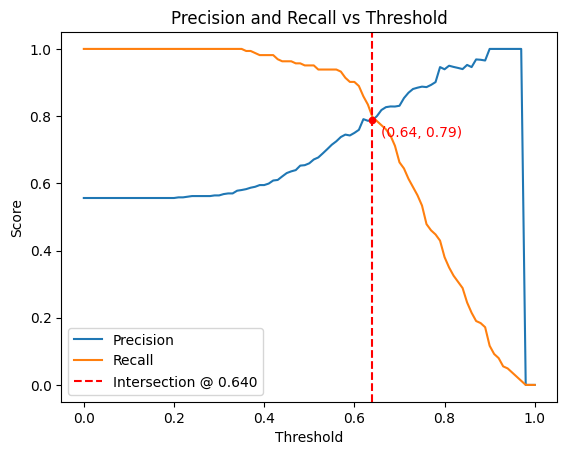

In [66]:
# Finding the point of intersection
precisions = df_scores.p.values
recalls = df_scores.r.values

mask = (precisions > 0.1) & (recalls > 0.1)
valid_thresholds = thresholds[mask]
valid_precisions = precisions[mask]
valid_recalls = recalls[mask]

intersection_idx = np.argmin(np.abs(valid_precisions - valid_recalls))
intersection_threshold = valid_thresholds[intersection_idx]
intersection_value = valid_precisions[intersection_idx]

plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')


# Indicating point of intersection on the graph
plt.axvline(intersection_threshold, color='red', linestyle='--', label=f'Intersection @ {intersection_threshold:.3f}')
plt.scatter(intersection_threshold, intersection_value, color='red', s=20, zorder=5)
plt.text(intersection_threshold + 0.02, intersection_value - 0.05, f"({intersection_threshold:.2f}, {intersection_value:.2f})", color='red', fontsize=10)



plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')

plt.legend()

Alternative Solution to Q3 without unnecessary computations

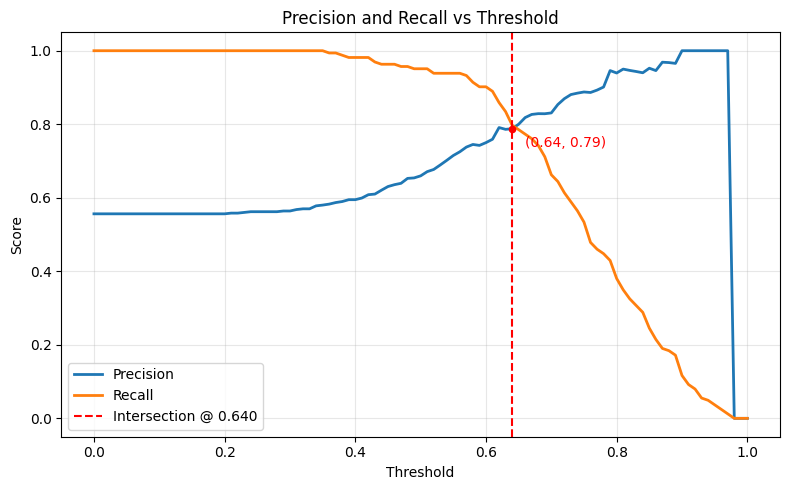

In [67]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)


precisions = []
recalls = []

for t in thresholds:
    y_pred_bin = (y_pred >= t).astype(int)
    p = precision_score(y_val, y_pred_bin, zero_division=0)
    r = recall_score(y_val, y_pred_bin, zero_division=0)
    precisions.append(p)
    recalls.append(r)

precisions = np.array(precisions)
recalls = np.array(recalls)

mask = (precisions > 0.1) & (recalls > 0.1)
valid_thresholds = thresholds[mask]
valid_precisions = precisions[mask]
valid_recalls = recalls[mask]

intersection_idx = np.argmin(np.abs(valid_precisions - valid_recalls))
intersection_threshold = valid_thresholds[intersection_idx]
intersection_value = valid_precisions[intersection_idx]

plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)

plt.axvline(intersection_threshold, color='red', linestyle='--', label=f'Intersection @ {intersection_threshold:.3f}')
plt.scatter(intersection_threshold, intersection_value, color='red', s=20, zorder=5)
plt.text(intersection_threshold + 0.02, intersection_value - 0.05, f"({intersection_threshold:.2f}, {intersection_value:.2f})", color='red', fontsize=10)

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.legend()

Q3 Ans: precision and recall curves intersect at 0.64

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [68]:
from sklearn.metrics import f1_score


thresholds = np.arange(0, 1.01, 0.01)

f1_scores = []

for t in thresholds:
    y_pred_bin = (y_pred >= t).astype(int)
    f1 = f1_score(y_val, y_pred_bin)
    f1_scores.append(f1)

f1_scores = np.array(f1_scores)

max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_score = f1_scores[max_f1_idx]

In [69]:
print(f"Maximum F1 score: {max_f1_score:.3f}")
print(f"Threshold (x) = {max_f1_threshold:.3f}")
print(f"Point = ({max_f1_threshold:.3f}, {max_f1_score:.3f})")

Maximum F1 score: 0.824
Threshold (x) = 0.570
Point = (0.570, 0.824)


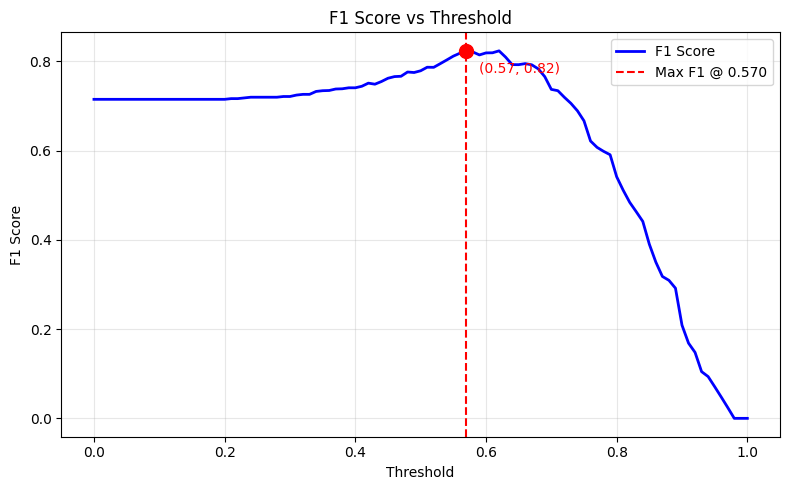

In [70]:
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2, color='blue')

plt.axvline(max_f1_threshold, color='red', linestyle='--', label=f'Max F1 @ {max_f1_threshold:.3f}')
plt.scatter(max_f1_threshold, max_f1_score, color='red', s=100, zorder=5)
plt.text(max_f1_threshold + 0.02, max_f1_score - 0.05,
         f"({max_f1_threshold:.2f}, {max_f1_score:.2f})",
         color='red', fontsize=10)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Q4 Ans: F1 is maximum at 0.824

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [71]:
from sklearn.model_selection import KFold

In [72]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    del df_train['converted']
    del df_val['converted']

    train_dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    pred_dicts = df_val.to_dict(orient='records')
    X_val = dv.transform(pred_dicts)

    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
print('Standard deviation: %.4f' % (np.std(scores)))

Standard deviation: 0.0353


Q5 Ans: The standard deviation across different fold is 0.0353 large

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [73]:
for C in [0.000001, 0.001, 1]:

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        del df_train['converted']
        del df_val['converted']

        train_dicts = df_train.to_dict(orient='records')
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dicts)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        pred_dicts = df_val.to_dict(orient='records')
        X_val = dv.transform(pred_dicts)

        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C = %s, mean = %.3f sd = %.3f' % (C, np.mean(scores), np.std(scores)))


C = 1e-06, mean = 0.540 sd = 0.030
C = 0.001, mean = 0.860 sd = 0.038
C = 1, mean = 0.827 sd = 0.035


Q6 Ans: C = 0.001 leads to the best mean score